#### Import

In [46]:
import easyocr
import os
import torch
import matplotlib.pyplot as plt
import random
import glob
from tqdm import tqdm
import numpy as np
import time
from mmocr_eval import eval_ocr_metric
import re
import cv2 as cv

#### Install packges

In [47]:
# !pip install matplotlib
# !pip install rapidfuzz

In [48]:
torch.cuda.is_available()

True

#### Training

Load model by easyOCR API (https://www.jaided.ai/easyocr/documentation/)

In [4]:
start = time.time()
model = 'crnn_30k_lr_5e-1'
iteration = 'iter_20000'

model_path = os.path.join('trainer', 'saved_models',model)
reader = easyocr.Reader(lang_list = ['en','th'],
                    model_storage_directory = model_path,
                    user_network_directory = os.path.join('my_model','user_network'),
                    recog_network  = iteration,
                    config_path = 'crnn',
                    gpu = True)
# reader = easyocr.Reader(lang_list = ['en','th'],gpu = True )
end = time.time()
print(f'loading model time: {end - start}')

--------------------
model_path: trainer\saved_models\crnn_30k_lr_5e-1\iter_20000.pth
config: my_model\user_network\crnn.yaml
--------------------
Transformation: None
FeatureExtraction: VGG
SequenceModeling: BiLSTM
Prediction: CTC
loading model time: 8.04795789718628


visualise testing with some image

In [56]:
list_im = [789, 782, 575, 779, 589, 714, 999 ,683]

 19%|█▉        | 3/16 [00:00<00:01,  7.14it/s]

[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]


 50%|█████     | 8/16 [00:00<00:00, 14.06it/s]

[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]


 69%|██████▉   | 11/16 [00:00<00:00, 16.63it/s]

[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]


100%|██████████| 16/16 [00:01<00:00, 12.33it/s]

[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]
[([[0, 0], [211, 0], [211, 98], [0, 98]], 'นิดดดด', 0.9999510407400403)]


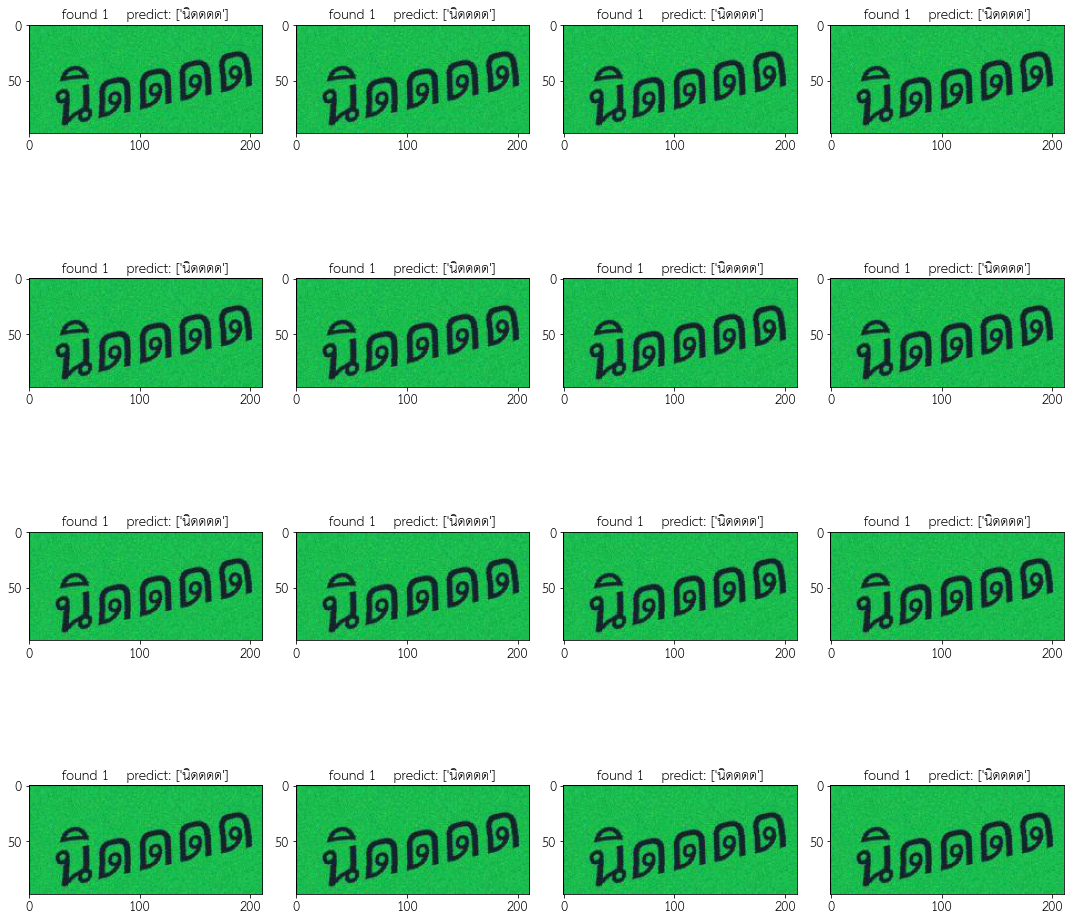

In [61]:
filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))

plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
columns = 4
rows = 4
fig = plt.figure(figsize=(15, 15))
ax = []
for i in tqdm(range(columns*rows)):
    # random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]

    # random_file_path = random.sample(filepaths,1)[0]
    random_file_path = filepaths[788]
    # random_file_path = filepaths[list_im.pop(0)]
    img = plt.imread(random_file_path)
    result = reader.recognize(random_file_path) 
    ax.append(fig.add_subplot(rows, columns, i+1) )
    print(result)
    boxs = []
    txt = []
    for idx,i in enumerate(result):
        boxs.append(i[0])
        txt.append(i[1])

    if len(result) > 0:
        ax[-1].set_title(f'found {idx+1}    predict: {txt}' , fontsize=20)
        for i in boxs:
            pts = np.array(i, np.int32)
            pts = pts.reshape((-1,1,2))
            cv.polylines(img,[pts],True,(0,0,0))

        
    else:
        ax[-1].set_title('No result', fontsize=20)
    plt.imshow(img)
fig.tight_layout() 
plt.show()

In [6]:
# filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
# label_path = 'trainer/all_data/testing/testing/label.txt'
# with open(label_path, encoding='utf8') as file:
#     label = np.loadtxt(file,dtype=str)
# word_correct = 0

In [7]:

# plt.rcParams['font.family'] = 'TH Sarabun New'
# columns = 5
# rows = 200
# fig, ax = plt.subplots(rows, columns, figsize=(20, 20))
# ax.set_facecolor("white")
# counter = 0
# for r in tqdm(range(rows)):
#     for c in range(columns):
#         file_name = re.split(r'[/\\]',filepaths[counter])[-1]
#         file_path = os.path.join('trainer/all_data/testing/testing',file_name)
#         img = plt.imread(file_path)
#         ax[r, c].axis('off')
#         result = reader.readtext(file_path) 
#         if len(result) > 0:
#             txt = ''
#             for i in result:
#                 txt += (' '+i[1])
#             ax[r, c].set_title(f'{file_name} predict: {txt}')
#         else:
#             ax[r, c].set_title('No result')
#         ax[r, c].imshow(img)
#         counter += 1
# plt.subplots_adjust(top = 20)

testing with all files in dataset

In [62]:
filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))
label_path = 'trainer/all_data/testing/testing/label.txt'
with open(label_path, encoding='utf8') as file:
    label = np.loadtxt(file,dtype=str)

start = time.time()
# filepaths = filepaths[:10]
pred = []
gt = [] # ground truth
name_img = []
for i in tqdm(range(len(filepaths))):
    label_img = label[i][1]
    name_img.append(label[i][0])
    result = reader.recognize(filepaths[i], batch_size = 8,detail=0)
    try:
        pred.append(result)
    except:
        pred.append('')
    gt.append(label_img)
end = time.time()
print(f'time: {end - start}')

100%|██████████| 1000/1000 [00:26<00:00, 37.74it/s]

time: 26.500922441482544


In [63]:
import mmocr_eval 
from importlib import reload
reload(mmocr_eval)
tmp = name_img.copy()
output, false_list = mmocr_eval.eval_ocr_metric(pred, gt, tmp)
# output, false_list = eval_ocr_metric(pred, gt, name_img)
for k,v in output.items():
    print(f'{k}: {v}')

char_recall: 0.8722
char_precision: 0.9342
word_acc: 0.542
word_acc_ignore_case: 0.551
word_acc_ignore_case_symbol: 0.805
1-N.E.D: 0.8956


In [12]:
for i in false_list:
    print(i)

['0.jpg', ['วอห์น]่'], 1, 'วอห์น']
['3.jpg', [], 0, 'ของ']
['4.jpg', ['รภัจฉ์'], 1, 'รภัจจ์']
['5.jpg', ['introducema'], 1, 'introduce']
['6.jpg', ['เ่รห'], 1, 'หากิน']
['7.jpg', ['พพฒฝ'], 1, 'พิพัฒ']
['9.jpg', [], 0, 'ลัวส์']
['11.jpg', ['Hermanl'], 1, 'Herman']
['12.jpg', ['ยื๋่น'], 1, 'ยิ้น']
['14.jpg', ['Certrew'], 1, 'Certre']
['15.jpg', ['Salotm'], 1, 'Salot']
['16.jpg', ['ท่ณ'], 1, 'ท่อ']
['17.jpg', [], 0, 'ซี่น']
['18.jpg', ["pepsin'"], 1, 'pepsin']
['20.jpg', ['ทารณ'], 1, 'ทารก']
['21.jpg', ['BamlumPoo '], 1, 'Bamlumpoo']
['24.jpg', [], 0, 'ภมูธ']
['25.jpg', ['pearls)'], 1, 'pearls']
['27.jpg', ['colonialism.'], 1, 'colonialism']
['28.jpg', ['นโกฎ-'], 1, 'นโกฎ']
['29.jpg', ['Bl'], 1, 'Blunt']
['30.jpg', ['ไพรัชk'], 1, 'ไพรัช']
['31.jpg', [], 0, 'บั้นท้าย']
['36.jpg', ['ธิรรมนูญ'], 1, 'ธรรมนูญ']
['41.jpg', ['Tokenismw'], 1, 'Tokenism']
['44.jpg', ['บพีท '], 1, 'บพีท']
['45.jpg', ['Rebec`'], 1, 'Rebec']
['47.jpg', ['ตรวลสอบ'], 1, 'ตรวจสอบ']
['48.jpg', [], 0, 'Overheating']
['49.

visualise testing with flase prediction

100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


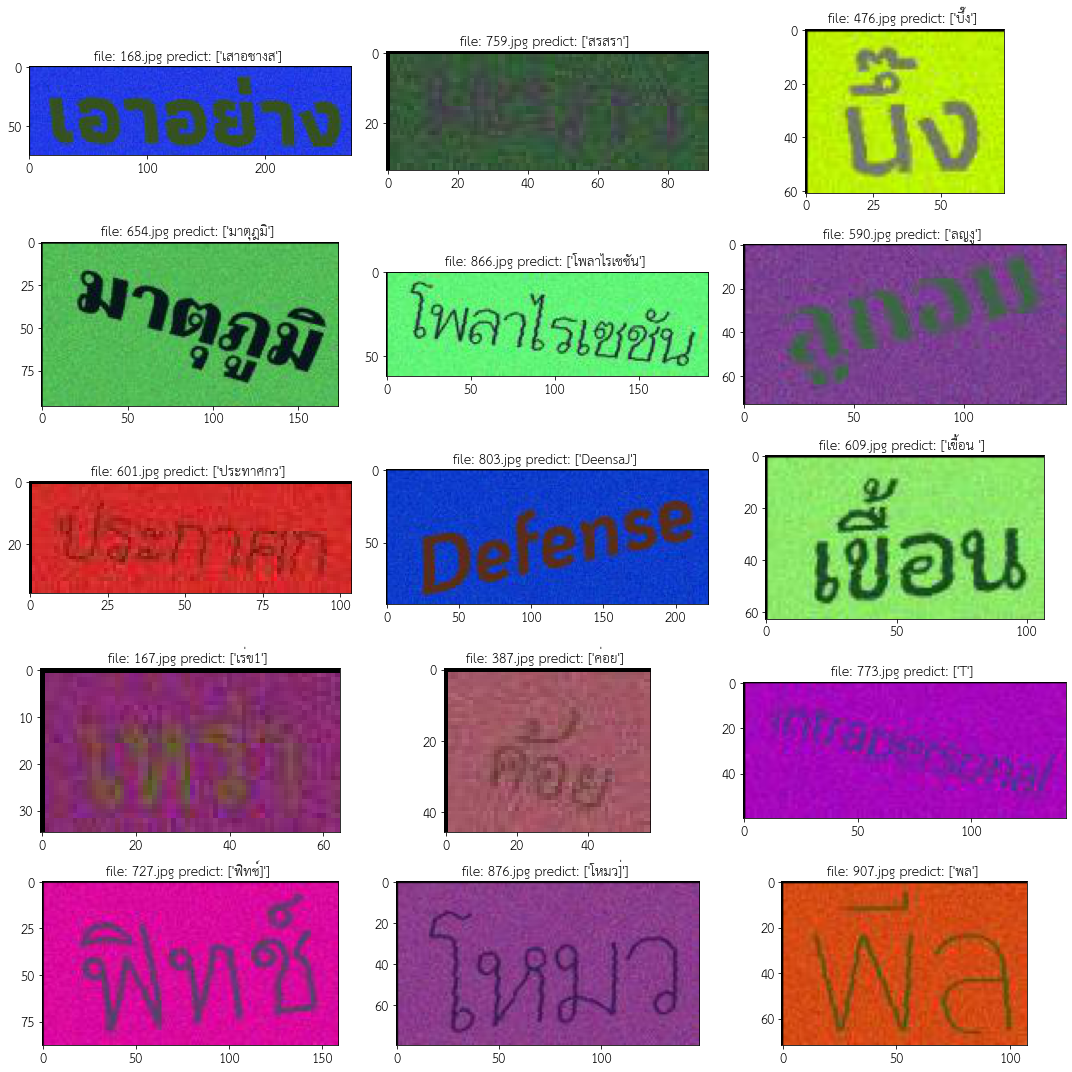

In [65]:
filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))

plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
columns = 3
rows = 5
fig = plt.figure(figsize=(15, 15))
ax = []
for i in tqdm(range(columns*rows)):
    # random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]

    random_file_name = random.sample(false_list,1)[0]
    random_file_name = random_file_name[0]
    random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)

    img = plt.imread(random_file_path)
    result = reader.recognize(random_file_path)
    ax.append(fig.add_subplot(rows, columns, i+1) )
    boxs = []
    txt = []
    for idx,i in enumerate(result):
        boxs.append(i[0])
        txt.append(i[1])


    if len(result) > 0:
        ax[-1].set_title(f'file: {random_file_name} predict: {txt} ', fontsize=20) 
        for i in boxs:
                pts = np.array(i, np.int32)
                pts = pts.reshape((-1,1,2))
                cv.polylines(img,[pts],True,(0,0,0))
    else:
        ax[-1].set_title(f'file: {random_file_name} No result', fontsize=20)
    plt.imshow(img)
fig.tight_layout() 
plt.show()

testing with LMWN

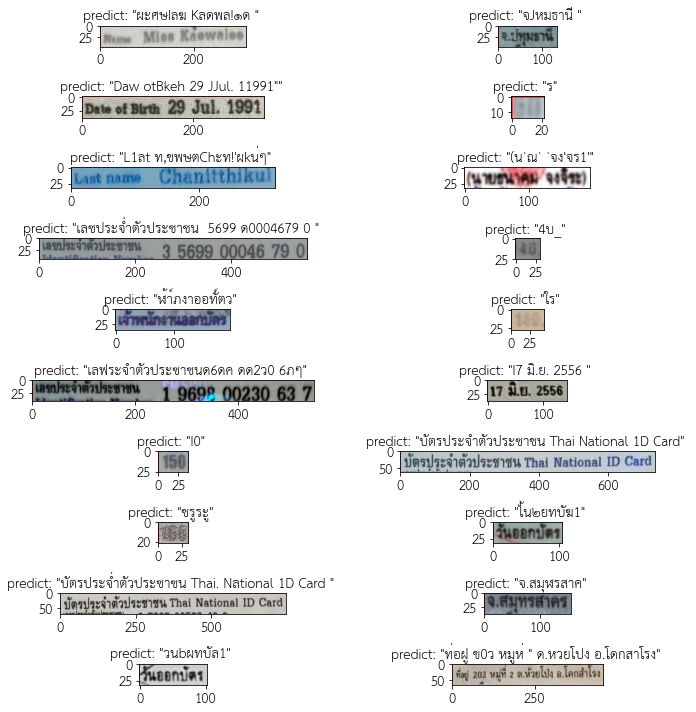

In [67]:
plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
columns = 2
rows = 10
fig = plt.figure(figsize=(10, 10))
ax = []
for i in range(columns*rows):
    random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/LMWN')),1)[0]
    # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    # random_file_name = os.listdir(os.path.join('trainer/all_data/testing/LMWN'))[2]
    random_file_path = os.path.join('trainer/all_data/testing/LMWN',random_file_name)
    img = plt.imread(random_file_path)
    result = reader.recognize(random_file_path) 
    ax.append(fig.add_subplot(rows, columns, i+1) )
    if len(result) > 0:
        ax[-1].set_title(f'predict: "{result[0][1]}" ', fontsize=20)
        # pts = np.array(result[0][0], np.int32)
        # pts = pts.reshape((-1,1,2))
        # cv.polylines(img,[pts],True,(255,0,0))
    else:
        ax[-1].set_title('No result',fontsize=20)
    plt.imshow(img)
fig.tight_layout() 
plt.show()